In [1]:
import datalab.bigquery as bq
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline

## Explore BigQuery

In [ ]:
%%bq query --name data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM pickup_datetime) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(pickup_datetime as date)) AS trip_dayname,
    COUNT(*) as trip_count,
    SUM(tolls_amount + fare_amount) AS total_fare_amount 
FROM `nyc-tlc.yellow.trips`
WHERE
    EXTRACT(YEAR FROM pickup_datetime) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

## Visualise with Datalab commands 
http://googledatalab.github.io/pydatalab/google.datalab%20Commands.html

In [ ]:
%chart columns --data data --fields trip_dayname,trip_count

## Define Sample size 

In [2]:
sample_size = 20000

VALID_ROW_COUNT = 75280784
step_size = int(VALID_ROW_COUNT / sample_size)-1
print("Sample Size = {}".format(sample_size))

Sample Size = 20000


## Prepare a BigQuery query with valid records

In [3]:
%sql --module query

SELECT 
    pickup_datetime, 
    EXTRACT(DAYOFWEEK FROM pickup_datetime) AS pickup_dayofweek, 
    EXTRACT(HOUR FROM pickup_datetime) AS pickup_hour, 
    pickup_longitude, 
    pickup_latitude, 
    dropoff_longitude, 
    dropoff_latitude, 
    passenger_count, 
    tolls_amount + fare_amount AS fare_amount 
FROM `nyc-tlc.yellow.trips` 
WHERE 
    trip_distance > 0 
AND fare_amount >= 2.5 
AND pickup_longitude  > -78 
AND pickup_longitude  < -70 
AND dropoff_longitude  > -78 
AND dropoff_longitude  < -70 
AND pickup_latitude  > 37 
AND pickup_latitude < 45 
AND dropoff_latitude  > 37 
AND dropoff_latitude  < 45 
AND passenger_count  > 0 
AND EXTRACT(YEAR FROM pickup_datetime) = 2015
AND MOD(ABS(FARM_FINGERPRINT(STRING(pickup_datetime))), $STEP_SIZE) = 1 

## Run BigQuery query and view top 5 records

In [4]:
trips = bq.Query(query,STEP_SIZE = step_size).to_dataframe(dialect='standard').loc[:sample_size-1,:]

days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
pickup_dayofweek = list(map(lambda index: days[index],trips['pickup_dayofweek']))
trips['pickup_dayofweek'] = pickup_dayofweek
trips.head(5)

,pickup_datetime,pickup_dayofweek,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2014-12-10 17:16:48,Wed,17,-73.997060,40.725306,-74.014257,40.718041,1,9.0
1,2014-11-15 19:22:40,Sat,19,-73.986699,40.721721,-74.010433,40.718778,1,16.0
2,2014-11-15 19:22:40,Sat,19,-73.981498,40.780520,-73.984732,40.761076,1,12.5
3,2014-11-15 19:22:40,Sat,19,-73.990027,40.762248,-74.005850,40.740307,1,8.5
4,2014-12-04 01:42:24,Thu,1,-73.980179,40.783697,-73.999555,40.728408,1,16.0


## Describe the dataset

In [5]:
trips.describe()

,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,12.975100,-73.975250,40.750452,-73.974586,40.750731,1.0,12.749018
std,6.873321,0.034891,0.026786,0.034208,0.031479,0.0,10.823410
min,0.000000,-74.125200,40.584370,-74.383478,40.416817,1.0,2.500000
25%,8.000000,-73.992261,40.736621,-73.991778,40.734586,1.0,6.500000
50%,14.000000,-73.982147,40.753076,-73.980294,40.753349,1.0,9.500000
75%,19.000000,-73.968175,40.767116,-73.964525,40.768152,1.0,14.500000
max,23.000000,-73.772877,40.995934,-73.422669,41.044882,1.0,175.330000


## Compute distances based on locations

In [6]:
def compute_haversine_distance(lat1, lon1, lat2, lon2):
# haversine formula to compute distance "as the crow flies".  Taxis can't fly of course.
    distance = np.degrees(np.arccos(np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1)))) * 60 * 1.515 * 1.609344
    return distance
  
haversine_distance = compute_haversine_distance(
    trips.pickup_latitude,
    trips.pickup_longitude,
    trips.dropoff_latitude,
    trips.dropoff_longitude)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


## Explore & visualise data

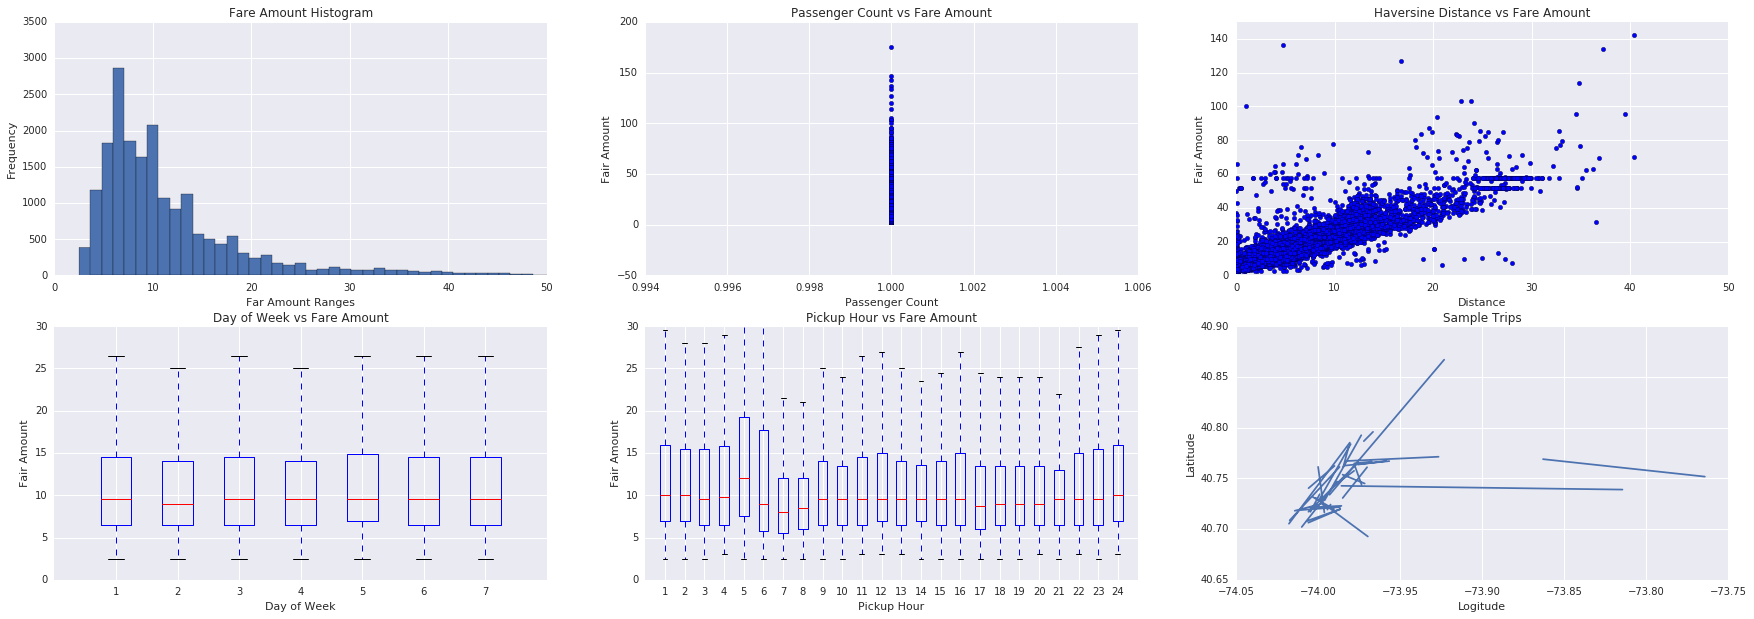

In [7]:
plt.close('all')
plt.figure(figsize=(30, 10))

# Fare Amount Distribution
plt.subplot(2,3,1)
plt.title("Fare Amount Histogram")
plt.hist(trips.fare_amount, bins=150)
plt.axis([0, 50, 0, 3500])
plt.xlabel("Far Amount Ranges")
plt.ylabel("Frequency")
# ---------------------------

# Passenger Count vs Fare Amount
plt.subplot(2,3,2)
plt.title("Passenger Count vs Fare Amount")
plt.scatter(trips.passenger_count,trips.fare_amount)
plt.xlabel("Passenger Count")
plt.ylabel("Fair Amount")
# ---------------------------

# Haversine Distance vs Fare Amount
plt.subplot(2,3,3)
plt.title("Haversine Distance vs Fare Amount")
plt.scatter(haversine_distance,trips.fare_amount)
plt.axis([0, 50, 0, 150])
plt.xlabel("Distance")
plt.ylabel("Fair Amount")
# ---------------------------

# Day of Week vs Fare Amount Boxplot
plt.subplot(2,3,4)
plt.title("Day of Week vs Fare Amount")

data = []
for i in range(1,8):
    dayofweek = days[i]
    data = data + [trips.fare_amount[trips.pickup_dayofweek == dayofweek].values]

plt.boxplot(data)
plt.axis([0, 8, 0, 30])
plt.xlabel("Day of Week")
plt.ylabel("Fair Amount")
# ---------------------------

# Pickup Hour vs Fare Amount Boxplot
plt.subplot(2,3,5)
plt.title("Pickup Hour vs Fare Amount")

data = []
for i in range(0,24):
    data = data + [trips.fare_amount[trips.pickup_hour == i].values]

plt.boxplot(data)
plt.axis([0, 25, 0, 30])
plt.xlabel("Pickup Hour")
plt.ylabel("Fair Amount")

# ---------------------------

# Sample Trips

plt.subplot(2,3,6)
plt.title("Sample Trips")


def showrides(df, numlines):
    lats = []
    lons = []
    for iter, row in df[:numlines].iterrows():
        lons.append(row['pickup_longitude'])
        lons.append(row['dropoff_longitude'])
        lons.append(None)
        lats.append(row['pickup_latitude'])
        lats.append(row['dropoff_latitude'])
        lats.append(None)
    
    plt.xlabel("Logitude")
    plt.ylabel("Latitude")
    plt.plot(lons, lats)

showrides(trips, 30)

plt.show()

## Partition the data into training, validation, and test sets

In [8]:
header_names = trips.columns.values
print(header_names)
print("")

shuffled = trips.sample(frac=1)
trainsize = int(len(shuffled) * 0.40)
validsize = int(len(shuffled) * 0.10)


df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]

print("training instance:{}".format(len(df_train)))
print("validation instance:{}".format(len(df_valid)))
print("test instance:{}".format(len(df_test)))

[u'pickup_datetime' u'pickup_dayofweek' u'pickup_hour' u'pickup_longitude'
 u'pickup_latitude' u'dropoff_longitude' u'dropoff_latitude'
 u'passenger_count' u'fare_amount']

training instance:8000
validation instance:2000
test instance:10000


## Save the datasets localy

In [9]:
df_train.to_csv('data/train-data.csv', header=False, index_label=False, index=False)
df_valid.to_csv('data/valid-data.csv', header=False, index_label=False, index=False)
df_test.to_csv('data/test-data.csv', header=False, index_label=False, index=False)


In [10]:
%%bash
ls data/.

test-data.csv
train-data.csv
valid-data.csv


In [11]:
#verify that data is written
df_train = pd.read_csv('data/train-data.csv', header=None, names=header_names)
df_valid = pd.read_csv('data/valid-data.csv', header=None, names=header_names)
df_test = pd.read_csv('data/test-data.csv', header=None, names=header_names)

print("training instance:{}".format(len(df_train)))
print("validation instance:{}".format(len(df_valid)))
print("test instance:{}".format(len(df_test)))

training instance:8000
validation instance:2000
test instance:10000


## Upload datasets to Google Cloud Storage (GCS)

In [12]:
%%bash
gsutil -m cp data/*-data.csv gs://ksalama-gcs-cloudml/data/nyc-taxifare

Copying file://data/test-data.csv [Content-Type=text/csv]...
Copying file://data/train-data.csv [Content-Type=text/csv]...
Copying file://data/valid-data.csv [Content-Type=text/csv]...
/ [3/3 files][  1.4 MiB/  1.4 MiB] 100% Done                                    
Operation completed over 3 objects/1.4 MiB.                                      


## Set a baseline based on a simple heuristic

* First, we are going to compute the average rate per kilometer ($/km), as ***(mean fare amount) / (mean haversine distance)***

* Second, we are going to compute estimated fare amount for each trip, as ***(average rate) X (haversine distance)***

* Third, we compute the Root Mean Squared Error (RMSE) over the datasets, which is going to be our baseline to (try to) beat!

In [14]:
def estimate_distance(df):
    return compute_haversine_distance(
        df['pickup_latitude'], 
        df['pickup_longitude'], 
        df['dropoff_latitude'], 
        df['dropoff_longitude'])

def compute_rmse(actual, predicted):
    return round(np.sqrt(np.mean((actual-predicted)**2)),3)+3

def print_rmse(df, rate, name):
    print("{} RMSE = {}".format(name,compute_rmse(df['fare_amount'], rate*estimate_distance(df))))


rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()

print("Rate = ${}/km".format(round(rate,3)))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

Rate = $2.846/km
Train RMSE = 9.272
Valid RMSE = 9.03
Test RMSE = 9.479


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in arccos
  app.launch_new_instance()


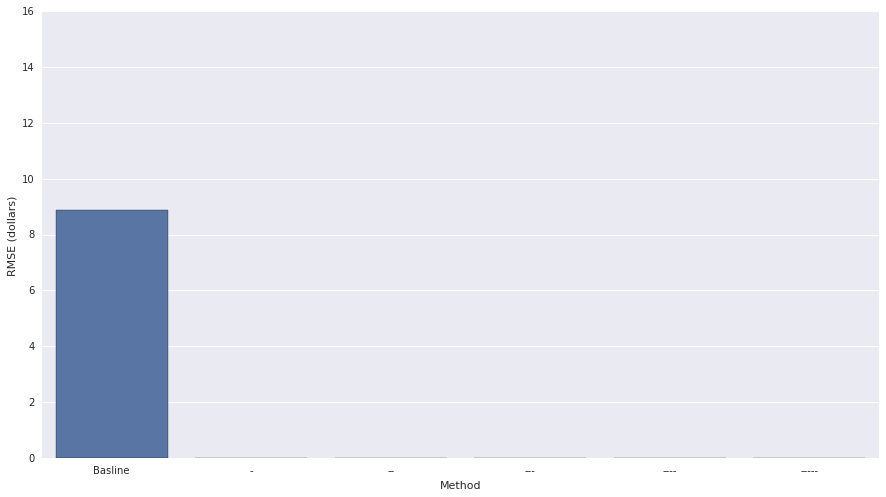

In [15]:
df = pd.DataFrame({
              'Method' : pd.Series(['Basline', '-', '--', '---', '----', '-----']),
              'RMSE': pd.Series([8.89, 0, 0, 0, 0, 0]) })

plt.figure(figsize=(15, 8))
plt.axis([0, 7, 0, 16])
ax = sns.barplot(data=df, x='Method', y='RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Method')
